# Experimentation: Data Pre-Processing
---

In [ ]:
# Import libraries
from monai.data import DataLoader
from monai.transforms import (EnsureChannelFirstd, ResizeWithPadOrCropd,
Compose, LoadImaged, MapTransform, Resized)

from monai.apps import TciaDataset
from monai.config import print_config

import torch
import matplotlib.pyplot as plt

print_config()


In [ ]:
# Specify the collection and segmentation type
collection, seg_type = "HCC-TACE-Seg", "SEG"

# Create a dictionary to map the labels in the segmentation to the labels in the image
label_dict = {'Liver': 0,
  'Mass': 1,
  'Necrosis': 2,
  'Portal vein': 3,
  'Abdominal aorta': 4}

class UndoOneHotEncoding(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)

    def __call__(self, data):
        for key in self.keys:
            data[key] = data[key].argmax(dim=0).unsqueeze(0)
        return data
    
class AddBackgroundChannel(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)

    def __call__(self, data):
        for key in self.keys:
            # Calculate the background channel
            background = 1 - data[key].sum(dim=0, keepdim=True)
            
            # Add the background channel to the segmentation
            data[key] = torch.cat([data[key], background], dim=0)
        return data
    
class AddNecrosisChannel(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)

    def __call__(self, data):
        for key in self.keys:
            # Check if the segmentation has less than 5 channels
            if data[key].shape[0] < 5:
                # Add an extra channel of zeros at the 3rd position
                zeros = torch.zeros((1, data[key].shape[1], data[key].shape[2], data[key].shape[3]))
                data[key] = torch.cat((data[key][:2], zeros, data[key][2:]), axis=0)
        return data

# Create a composed transform that loads the image and segmentation, resamples the image to match the segmentation,
# undoes the one-hot encoding of the segmentation, and adds the necrosis channel if necessary
transform = Compose(
    [
        LoadImaged(reader="PydicomReader", keys=["image", "seg"], label_dict=label_dict),
        EnsureChannelFirstd(keys=["image", "seg"]),
        ResizeWithPadOrCropd(keys=["image", "seg"], spatial_size=[512, 512, 64]),        
        #UndoOneHotEncoding(keys="seg"),
        AddNecrosisChannel(keys="seg"),
        AddBackgroundChannel(keys="seg"),
        Resized(keys=["image", "seg"], spatial_size=[64, 64, 64])
    ]
)
    
# Create a dataset for the training with a validation split
train_dataset = TciaDataset(
    root_dir="../data",
    collection=collection,
    section="training",
    transform=transform,
    download=True,
    download_len=2,
    seg_type=seg_type,
    progress=True,
    cache_rate=0.0,
    val_frac=0.0,
    seed=0,
)

# Create a dataset for the training with a validation split
test_dataset = TciaDataset(
    root_dir="../data",
    collection=collection,
    section="test",
    transform=transform,
    download=True,
    download_len=2,
    seg_type=seg_type,
    progress=True,
    cache_rate=0.0,
    val_frac=0.0,
    seed=100,
)

In [ ]:
# Create a dataloader
train_loader = DataLoader(train_dataset, batch_size=1, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0) 

In [ ]:
# Sample a batch of data from the dataloader
batch = next(iter(train_loader))

In [ ]:
# Print the batch data keys
print(batch.keys())

# Print the batch data shapes
print(batch["image"].shape, batch["seg"].shape)

# Print the batch data types
print(batch["image"].dtype, batch["seg"].dtype)

In [ ]:
# Separate the image and segmentation from the batch
image, seg = batch["image"], batch["seg"]

In [ ]:
slice_idx =60

# Sample a slice from the image
CT_slice = image[0, 0, :, :, slice_idx].cpu()

# Get the maximum segmentation class for each pixel in the slice
CT_seg_slice = seg[0,0, :, :, slice_idx].cpu()

print(CT_slice.shape, CT_seg_slice.shape)

# Plot the image and segmentation slice as a subplot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(CT_slice, cmap="gray")
axes[0].set_title("CT Image")
axes[1].imshow(CT_seg_slice, cmap="jet")
axes[1].set_title("CT Segmentation")
plt.colorbar(mappable=axes[1].imshow(CT_seg_slice, cmap='jet'), ax=axes[1])
plt.show()

In [ ]:
import torch
print(torch.cuda.is_available())

# Set the device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(image.shape, seg.shape)

In [ ]:
from monai.networks.nets import SwinUNETR

# Create a Swin-UNet model
model = SwinUNETR(img_size=(64, 64, 64), in_channels=1, out_channels=5, use_v2 = True, spatial_dims=3)

In [ ]:
# Set the model to use the GPU
model = model.to(device)

# Set the hyperparameters for training
max_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-5
val_interval = 1
checkpoint_dir = "./runs"

# Set the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
loss_function = torch.nn.CrossEntropyLoss()

# Create the training loop

# Set the model to training mode
model.train()

# Iterate over the training data for the specified number of epochs
for epoch in range(max_epochs):
    for batch in train_loader:
        # Extract the image and segmentation from the batch
        image, seg = batch["image"].to(device), batch["seg"].to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(image)
        
        # Compute the loss
        loss = loss_function(output, torch.argmax(seg, dim=1))
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
    # Print the loss for each epoch
    print(f"Epoch [{epoch+1}/{max_epochs}], Loss: {loss.item():.4f}")
    
    # Set the model to evaluation mode
    model.eval()
    
    # Compute the validation loss
    with torch.no_grad():
        for batch in test_loader:
            image, seg = batch["image"].to(device), batch["seg"].to(device)
            output = model(image)
            loss = loss_function(output, torch.argmax(seg, dim=1))
        print(f"Validation Loss: {loss.item():.4f}")

In [18]:
# Save the model
torch.save(model.state_dict(), "../models/swin_unetr.pth")

In [32]:
ex = torch.tensor([0, 0, 0, 0])
print(ex.shape)
max_ex = torch.argmax(ex, dim=0)    
print(max_ex)
print(ex[max_ex])

torch.Size([4])
tensor(0)
tensor(0)


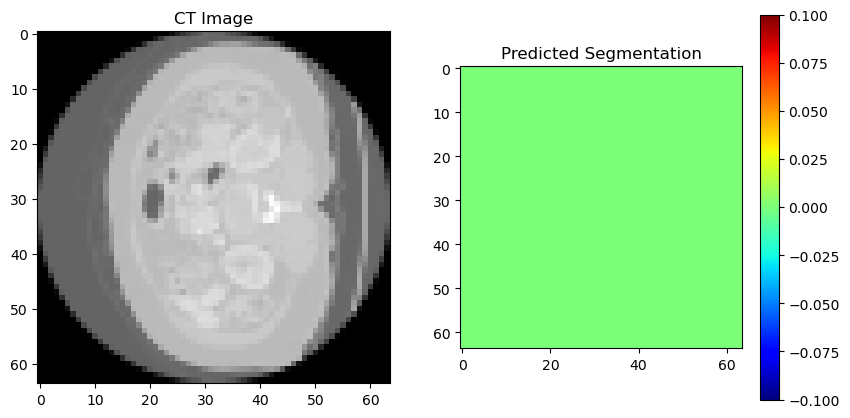

In [21]:
# Load the model
model.load_state_dict(torch.load("../models/swin_unetr.pth"))

# Set the model to evaluation mode
model.eval()

# Sample a batch of data from the test dataloader to make predictions
batch = next(iter(test_loader))

# Extract the image and segmentation from the batch
image, seg = batch["image"].to(device), batch["seg"].to(device)

# Make predictions on the image
output = model(image)

# Get the predicted segmentation class for each pixel
pred_seg = torch.argmax(output, dim=1)

# Visualize the predicted segmentation
slice_idx = 60
CT_slice = image[0, 0, :, :, slice_idx].cpu()
CT_seg_slice = pred_seg[0, :, :, slice_idx].cpu()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(CT_slice, cmap="gray")
axes[0].set_title("CT Image")
axes[1].imshow(CT_seg_slice, cmap="jet")
axes[1].set_title("Predicted Segmentation")
plt.colorbar(mappable=axes[1].imshow(CT_seg_slice, cmap='jet'), ax=axes[1])
plt.show()
